In [2]:
# pip install ultralytics

In [3]:
import os
import torch

print("Current directory:", os.getcwd())
print("PyTorch:", torch.__version__)
print("MPS available:", torch.backends.mps.is_available())

device = "mps" if torch.backends.mps.is_available() else "cpu"
print("Using device:", device)

Current directory: /Users/omadj/Desktop/This PC/Samsung128/HOMEWORK/FALL 2025/II. MACHINE LEARNING/GROUP PROJECT/src
PyTorch: 2.9.1
MPS available: True
Using device: mps


In [4]:
# %%
yaml_path = "../dataset/dataset.yaml"

yaml_text = """
path: ../dataset
train: train/images
val: valid/images
test: test/images

names:
  0: tumor
"""

with open(yaml_path, "w") as f:
    f.write(yaml_text.strip())

print("Wrote dataset.yaml")
print(yaml_text)

Wrote dataset.yaml

path: ../dataset
train: train/images
val: valid/images
test: test/images

names:
  0: tumor



Visual sanity test

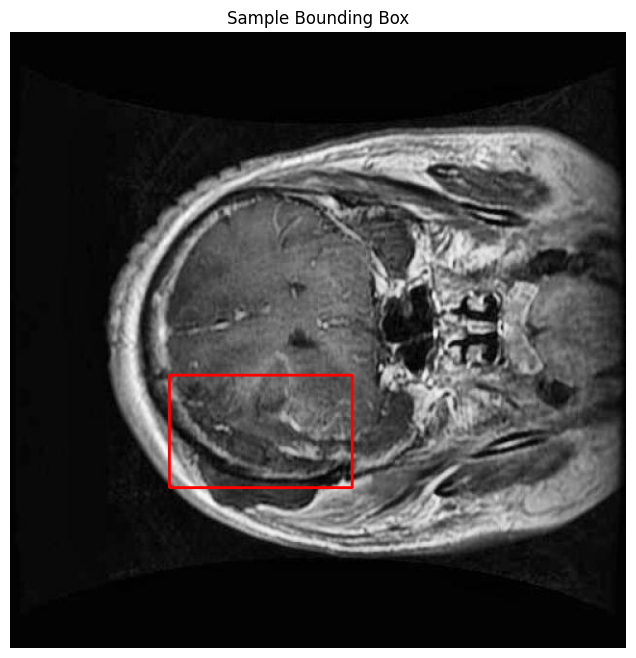

In [5]:
import json, cv2, random
import matplotlib.pyplot as plt

train_ann = "../dataset/train/_annotations.coco.json"
with open(train_ann, "r") as f:
    coco = json.load(f)

img_meta = random.choice(coco["images"])
fn = img_meta["file_name"]

img_path = f"../dataset/train/images/{fn}"
img = cv2.imread(img_path)
assert img is not None, f"Missing image: {img_path}"

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def draw_box(img, bbox, color=(255,0,0)):
    x,y,w,h = map(int,bbox)
    cv2.rectangle(img, (x,y), (x+w,y+h), color, 2)

anns = [a for a in coco["annotations"] if a["image_id"]==img_meta["id"]]
for ann in anns:
    draw_box(img, ann["bbox"])

plt.figure(figsize=(8,8))
plt.imshow(img)
plt.axis("off")
plt.title("Sample Bounding Box")
plt.show()

Convert COCO → YOLO

In [6]:
import json, os

def coco_to_yolo(coco_json_path, images_dir, labels_dir, class_id=0):
    os.makedirs(labels_dir, exist_ok=True)
    coco = json.load(open(coco_json_path, "r"))

    sizes = {
        img["id"]: (img["width"], img["height"], img["file_name"])
        for img in coco["images"]
    }

    ann_by_img = {}
    for ann in coco["annotations"]:
        ann_by_img.setdefault(ann["image_id"], []).append(ann)

    count = 0

    for img_id, anns in ann_by_img.items():
        w, h, fname = sizes[img_id]

        lab = fname.rsplit(".",1)[0] + ".txt"
        out = os.path.join(labels_dir, lab)

        with open(out, "w") as f:
            for ann in anns:
                x,y,bw,bh = ann["bbox"]

                cx = (x + bw/2) / w
                cy = (y + bh/2) / h
                nw = bw / w
                nh = bh / h

                f.write(f"{class_id} {cx} {cy} {nw} {nh}\n")

        count += 1

    print(f"Converted {count} labels → {labels_dir}")

Run conversion (train, valid, test)

In [7]:
root = "../dataset"

coco_to_yolo(
    f"{root}/train/_annotations.coco.json",
    f"{root}/train/images",
    f"{root}/train/labels"
)

coco_to_yolo(
    f"{root}/valid/_annotations.coco.json",
    f"{root}/valid/images",
    f"{root}/valid/labels"
)

os.makedirs(f"{root}/test/labels", exist_ok=True)
print("Prepared test labels.")

Converted 1501 labels → ../dataset/train/labels
Converted 429 labels → ../dataset/valid/labels
Prepared test labels.


Clean corrupted labels

In [8]:
train_images = "../dataset/train/images"
train_labels = "../dataset/train/labels"

deleted = 0

for txt in os.listdir(train_labels):
    if not txt.endswith(".txt"):
        continue
    base = txt[:-4]

    candidates = [base + ext for ext in [".jpg",".jpeg",".png"]]

    exists = any(os.path.exists(os.path.join(train_images, c)) for c in candidates)
    if not exists:
        os.remove(os.path.join(train_labels, txt))
        deleted += 1

print("Deleted corrupted labels:", deleted)

Deleted corrupted labels: 0


Delete .cache before training

In [9]:
import glob

for cache in glob.glob("../dataset/**/*.cache", recursive=True):
    print("Deleting:", cache)
    os.remove(cache)

print("Cache cleared.")

Deleting: ../dataset/valid/labels.cache
Deleting: ../dataset/train/labels.cache
Cache cleared.


Train YOLOv8s (correct dirs)

In [10]:
from ultralytics import YOLO

yaml_path = "../dataset/dataset.yaml"
assert os.path.exists(yaml_path)

model = YOLO("yolov8s.pt")

results = model.train(
    data="../dataset/dataset.yaml",
    epochs=30,
    imgsz=640,
    batch=8,
    device=device,
    task="detect",
    project="../experiments",
    name="yolo_run8",
    save=True,
    save_period=1,

    # ONLY AUGMENTATIONS SAFE IN YOUR VERSION
    fliplr=0.5,
    flipud=0.0,

    # FORCE all other augmentations OFF using the global switch
    augment=False
)

print("Training complete → ../experiments/yolo_run8")

New https://pypi.org/project/ultralytics/8.3.234 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.233 🚀 Python-3.13.2 torch-2.9.1 MPS (Apple M4 Max)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../dataset/dataset.yaml, degrees=0.0, deterministic=True, device=mps, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo_run8, nbs=64, nms=False, opset=None, optimize=False, o

In [22]:
# %%
# Run YOLO inference on validation set, save detections in txt format.

!yolo predict \
    model=../experiments/yolo_run8/weights/best.pt \
    source=../dataset/valid/images \
    save_txt=True \
    save_conf=True \
    conf=0.25 \
    max_det=10 \
    project=../experiments \
    name=yolo_run8_val_preds \
    exist_ok=True

Ultralytics 8.3.233 🚀 Python-3.13.2 torch-2.9.1 CPU (Apple M4 Max)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs

image 1/429 /Users/omadj/Desktop/This PC/Samsung128/HOMEWORK/FALL 2025/II. MACHINE LEARNING/GROUP PROJECT/src/../dataset/valid/images/1001_jpg.rf.a64df329f81626672c9b81f95d421c84.jpg: 640x640 1 tumor, 65.9ms
image 2/429 /Users/omadj/Desktop/This PC/Samsung128/HOMEWORK/FALL 2025/II. MACHINE LEARNING/GROUP PROJECT/src/../dataset/valid/images/1006_jpg.rf.9e260b2c3d87e68b706022359921b4e0.jpg: 640x640 1 tumor, 52.2ms
image 3/429 /Users/omadj/Desktop/This PC/Samsung128/HOMEWORK/FALL 2025/II. MACHINE LEARNING/GROUP PROJECT/src/../dataset/valid/images/1007_jpg.rf.bf4640f845748bd0c7fe976a3c5e521e.jpg: 640x640 1 tumor, 51.3ms
image 4/429 /Users/omadj/Desktop/This PC/Samsung128/HOMEWORK/FALL 2025/II. MACHINE LEARNING/GROUP PROJECT/src/../dataset/valid/images/1009_jpg.rf.230f70b84d8d461b7c40b7ce30cd0ced.jpg: 640x640 1 tumor, 52.2ms
image 5/429 /Users

Output Folder: ../experiments/yolo_run8_val_preds/labels/

Load COCO GT boxes

In [25]:
# %%
import json
import os

gt_file = "../dataset/valid/_annotations.coco.json"

with open(gt_file, "r") as f:
    coco = json.load(f)

# dict: filename → [xyxy_box]
gt_boxes = {}

for img in coco["images"]:
    gt_boxes[img["file_name"]] = {
        "w": img["width"],
        "h": img["height"],
        "boxes": []
    }

for ann in coco["annotations"]:
    fname = next(x["file_name"] for x in coco["images"] if x["id"] == ann["image_id"])
    x, y, w, h = ann["bbox"]
    gt_boxes[fname]["boxes"].append([x, y, x+w, y+h])   # xyxy

Load YOLO predictions

In [26]:
# %%
import glob

pred_dir = "../experiments/yolo_run8_val_preds/labels"
pred_files = sorted(glob.glob(os.path.join(pred_dir, "*.txt")))

pred_boxes = {}   # filename → [xyxy]

for pf in pred_files:
    fname = os.path.basename(pf).replace(".txt", "")
    
    # recover actual image filename (jpg)
    candidates = [
        fname + ".jpg",
        fname + ".jpeg",
        fname + ".png"
    ]
    img_name = None
    for c in candidates:
        if c in gt_boxes:
            img_name = c
            break
    if img_name is None:
        continue
    
    # read top-confidence prediction (first line)
    with open(pf, "r") as f:
        lines = f.readlines()
    if len(lines) == 0:
        continue

    best = lines[0].strip().split()
    _, cx, cy, w, h, conf = best
    cx, cy, w, h = map(float, [cx, cy, w, h])

    W = gt_boxes[img_name]["w"]
    H = gt_boxes[img_name]["h"]

    # convert from normalized YOLO to absolute xyxy
    bw = w * W
    bh = h * H
    x1 = cx*W - bw/2
    y1 = cy*H - bh/2
    x2 = x1 + bw
    y2 = y1 + bh

    pred_boxes[img_name] = [x1, y1, x2, y2]

IoU function

In [27]:
# %%
def iou_xyxy(a, b):
    xa1, ya1, xa2, ya2 = a
    xb1, yb1, xb2, yb2 = b

    ix1 = max(xa1, xb1)
    iy1 = max(ya1, yb1)
    ix2 = min(xa2, xb2)
    iy2 = min(ya2, yb2)

    inter = max(0, ix2 - ix1) * max(0, iy2 - iy1)

    area_a = (xa2 - xa1) * (ya2 - ya1)
    area_b = (xb2 - xb1) * (yb2 - yb1)

    union = area_a + area_b - inter

    return inter / union if union > 0 else 0.0

Compute IoU per image + Average IoU

In [28]:
# %%
ious = []

for fname, gt in gt_boxes.items():
    if fname not in pred_boxes:
        continue
    
    if len(gt["boxes"]) == 0:
        continue
    
    # dataset has exactly one GT box per MRI
    gt_box = gt["boxes"][0]
    pred_box = pred_boxes[fname]

    value = iou_xyxy(pred_box, gt_box)
    ious.append(value)

import numpy as np
mean_iou = np.mean(ious) if len(ious) else 0

print("Images evaluated:", len(ious))
print("Mean IoU:", round(mean_iou, 4))

Images evaluated: 413
Mean IoU: 0.7299


Show histogram of IoU values

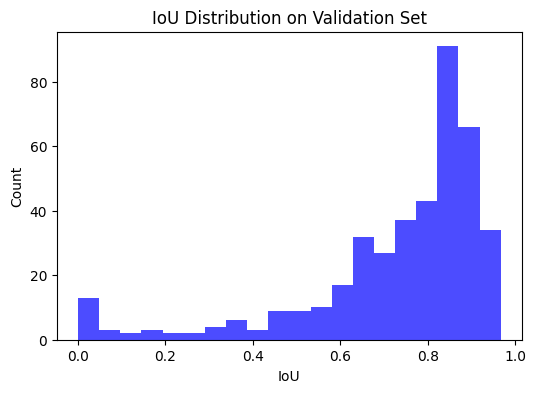

In [29]:
# %%
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(ious, bins=20, color="blue", alpha=0.7)
plt.title("IoU Distribution on Validation Set")
plt.xlabel("IoU")
plt.ylabel("Count")
plt.show()

***

Pixel Accuracy

***

In [30]:
# %%
import numpy as np
import cv2
import os

val_img_dir = "../dataset/valid/images"

pixel_accs = []

for fname, gt in gt_boxes.items():
    img_path = os.path.join(val_img_dir, fname)
    if not os.path.exists(img_path):
        continue
    
    # -----------------------
    # Load GT mask (polygon → binary mask)
    # -----------------------
    H = gt["h"]
    W = gt["w"]
    gt_mask = np.zeros((H, W), dtype=np.uint8)

    # only one annotation per image in this dataset
    if len(gt["boxes"]):
        # reconstruct polygon mask
        anns = [a for a in coco["annotations"] if a["image_id"] ==
                next(x["id"] for x in coco["images"] if x["file_name"] == fname)]
        for ann in anns:
            if "segmentation" in ann and ann["segmentation"]:
                pts = np.array(ann["segmentation"][0], dtype=np.int32).reshape(-1,2)
                cv2.fillPoly(gt_mask, [pts], 1)
    
    # -----------------------
    # Load predicted bounding box → convert to mask
    # -----------------------
    if fname not in pred_boxes:
        continue
    
    pred_box = pred_boxes[fname]  # xyxy
    x1, y1, x2, y2 = map(int, pred_box)

    pred_mask = np.zeros((H, W), dtype=np.uint8)
    cv2.rectangle(pred_mask, (x1,y1), (x2,y2), 1, thickness=-1)
    
    # -----------------------
    # Compute pixel accuracy
    # -----------------------
    TP = np.sum((pred_mask == 1) & (gt_mask == 1))
    TN = np.sum((pred_mask == 0) & (gt_mask == 0))
    FP = np.sum((pred_mask == 1) & (gt_mask == 0))
    FN = np.sum((pred_mask == 0) & (gt_mask == 1))

    acc = (TP + TN) / (TP + TN + FP + FN + 1e-8)
    pixel_accs.append(acc)

In [31]:
# %%
pixel_accuracy = np.mean(pixel_accs)
print("Pixel Accuracy:", round(pixel_accuracy, 4))
print("Samples evaluated:", len(pixel_accs))

Pixel Accuracy: 0.9863
Samples evaluated: 413


***

Test Data:

Run YOLO on the test directory

In [37]:
# %%
from ultralytics import YOLO
import os

model_path = "../experiments/yolo_run8/weights/best.pt"
test_img_dir = "../dataset/test/images"

assert os.path.exists(model_path)
assert os.path.exists(test_img_dir)

model = YOLO(model_path)

pred_results = model.predict(
    source=test_img_dir,
    conf=0.25,         # use same as validation
    save_txt=True,
    save_conf=True,
    project="../experiments",
    name="yolo_run8_test_preds",
    exist_ok=True
)

print("✓ YOLO predictions complete.")


image 1/215 /Users/omadj/Desktop/This PC/Samsung128/HOMEWORK/FALL 2025/II. MACHINE LEARNING/GROUP PROJECT/src/../dataset/test/images/1030_jpg.rf.4bfc0ebc72d835cb9668219cd911c249.jpg: 640x640 1 tumor, 68.2ms
image 2/215 /Users/omadj/Desktop/This PC/Samsung128/HOMEWORK/FALL 2025/II. MACHINE LEARNING/GROUP PROJECT/src/../dataset/test/images/1035_jpg.rf.0dead1ccbe6b1e137ca2d98fc4d34b9a.jpg: 640x640 1 tumor, 57.3ms
image 3/215 /Users/omadj/Desktop/This PC/Samsung128/HOMEWORK/FALL 2025/II. MACHINE LEARNING/GROUP PROJECT/src/../dataset/test/images/1056_jpg.rf.f539615badbea313d68c957e76642dda.jpg: 640x640 1 tumor, 56.0ms
image 4/215 /Users/omadj/Desktop/This PC/Samsung128/HOMEWORK/FALL 2025/II. MACHINE LEARNING/GROUP PROJECT/src/../dataset/test/images/1058_jpg.rf.f6d6dcde9564c091b30eb6873641ba36.jpg: 640x640 2 tumors, 56.2ms
image 5/215 /Users/omadj/Desktop/This PC/Samsung128/HOMEWORK/FALL 2025/II. MACHINE LEARNING/GROUP PROJECT/src/../dataset/test/images/1083_jpg.rf.b1473a76f8f3789c6be693dfb

 Copy YOLO test predictions into dataset/test/labels

In [38]:
# %%
import os
import shutil

src = "../experiments/yolo_run8_test_preds/labels"
dst = "../dataset/test/labels"

os.makedirs(dst, exist_ok=True)

# copy *.txt
for fname in os.listdir(src):
    if fname.endswith(".txt"):
        shutil.copy(os.path.join(src, fname), os.path.join(dst, fname))

print("✓ Copied predictions → dataset/test/labels")
print("Files:", len(os.listdir(dst)))

✓ Copied predictions → dataset/test/labels
Files: 208


Recreate COCO JSON but using dataset/test/labels

In [45]:
# %% 
import os
import json
from datetime import datetime, timezone

test_img_dir = "../dataset/test/images"
test_label_dir = "../dataset/test/labels"

# ===============================
# COCO ROOT STRUCTURE
# ===============================
coco = {
    "info": {
        "year": "2025",
        "version": "1",
        "description": "Predicted by YOLOv8",
        "contributor": "Omar Madjitov",
        "url": "",
        "date_created": datetime.now(timezone.utc).isoformat()
    },
    "licenses": [
        {
            "id": 1,
            "url": "https://creativecommons.org/licenses/by/4.0/",
            "name": "CC BY 4.0"
        }
    ],
    "categories": [
        {"id": 0, "name": "Tumor", "supercategory": "none"},
        {"id": 1, "name": "0", "supercategory": "Tumor"},
        {"id": 2, "name": "1", "supercategory": "Tumor"}
    ],
    "images": [],
    "annotations": []
}

# ===============================
# BUILD IMAGES LIST
# ===============================
img_files = sorted(os.listdir(test_img_dir))
img_id = 0

for fname in img_files:
    if not fname.lower().endswith((".jpg", ".jpeg", ".png")):
        continue

    coco["images"].append({
        "id": img_id,
        "license": 1,
        "file_name": fname,
        "height": 640,
        "width": 640,
        "date_captured": datetime.now(timezone.utc).isoformat()
    })
    img_id += 1

# ===============================
# BUILD ANNOTATIONS
# ===============================
ann_id = 0

for im in coco["images"]:
    fname = im["file_name"]
    w = im["width"]
    h = im["height"]

    txt_path = os.path.join(
        test_label_dir,
        fname.replace(".jpg", ".txt").replace(".jpeg", ".txt").replace(".png", ".txt")
    )

    if not os.path.exists(txt_path):
        continue

    with open(txt_path, "r") as f:
        lines = [x.strip() for x in f.readlines() if x.strip()]

    for line in lines:
        parts = line.split()

        if len(parts) < 5:
            continue

        cls = int(parts[0])
        xc, yc, bw, bh = map(float, parts[1:5])

        # Convert YOLO → COCO (absolute coordinates)
        x_min = (xc - bw / 2) * w
        y_min = (yc - bh / 2) * h
        box_w = bw * w
        box_h = bh * h
        x_max = x_min + box_w
        y_max = y_min + box_h

        # Rectangular segmentation
        segmentation = [[
            x_max, y_min,
            x_min, y_min,
            x_min, y_max,
            x_max, y_max,
            x_max, y_min
        ]]

        coco["annotations"].append({
            "id": ann_id,
            "image_id": im["id"],
            "category_id": cls,
            "bbox": [x_min, y_min, box_w, box_h],
            "area": box_w * box_h,
            "segmentation": segmentation,
            "iscrowd": 0
        })

        ann_id += 1

print("Images:", len(coco["images"]))
print("Annotations:", len(coco["annotations"]))

# ===============================
# SAVE JSON
# ===============================
output_path = "../dataset/test/_annotations.coco.json"

with open(output_path, "w") as f:
    json.dump(coco, f, indent=2)

print("Saved COCO JSON →", output_path)

Images: 215
Annotations: 255
Saved COCO JSON → ../dataset/test/_annotations.coco.json


***

Vizual Check of the TEST Images

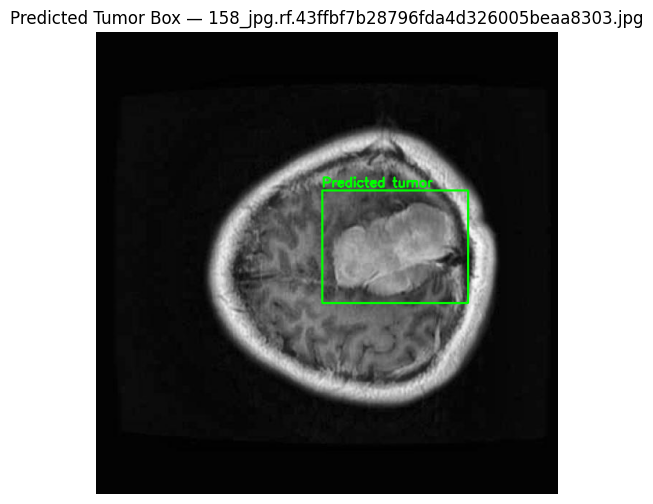

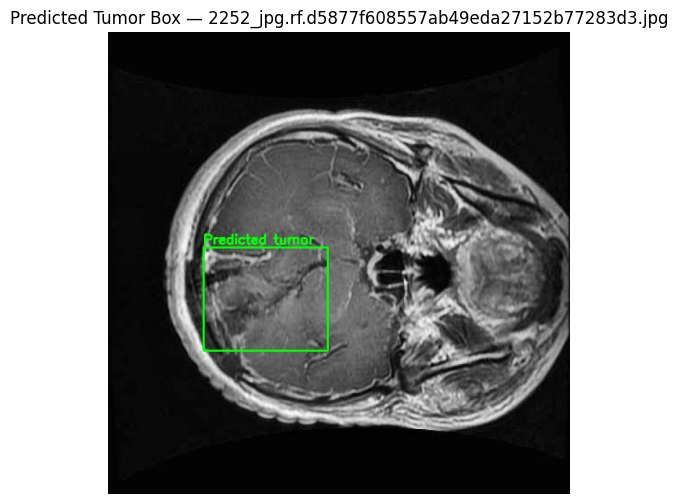

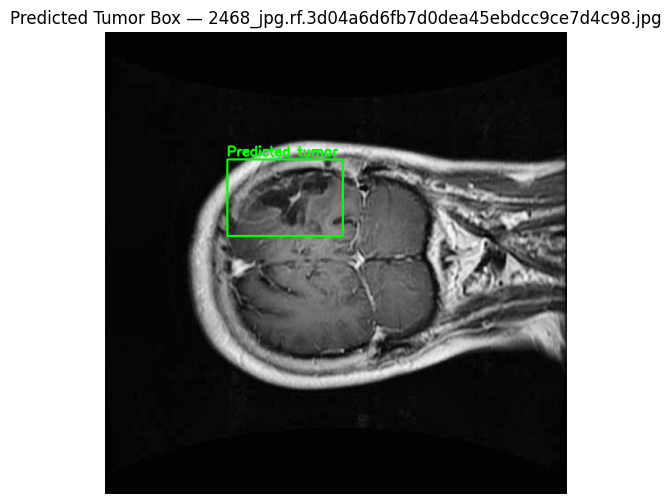

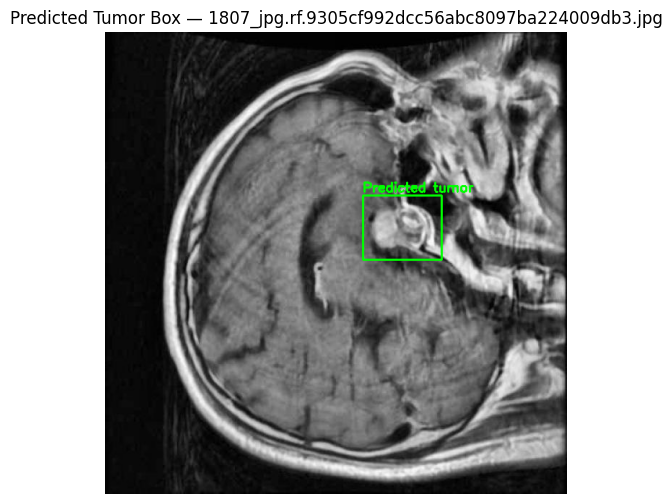

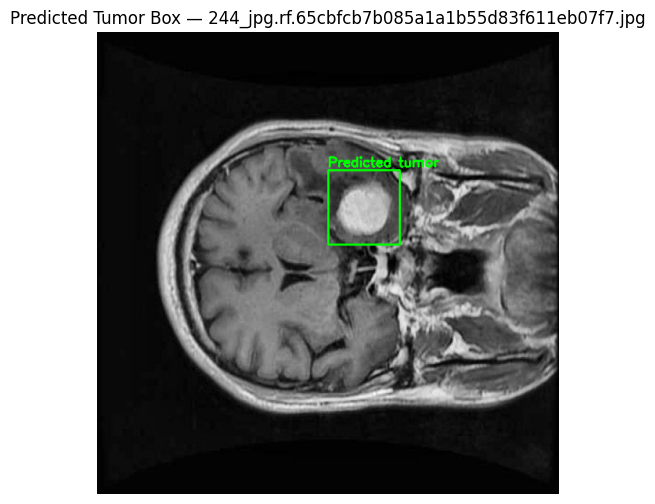

In [50]:
# %%
import os
import random
import cv2
import matplotlib.pyplot as plt

test_img_dir = "../dataset/test/images"
test_label_dir = "../dataset/test/labels"

# get .jpg/.png images
img_files = sorted([
    f for f in os.listdir(test_img_dir)
    if f.lower().endswith((".jpg", ".jpeg", ".png"))
])

# pick 5 random images
samples = random.sample(img_files, 5)

def load_yolo_boxes(label_path, w, h):
    """Load YOLO txt → absolute xyxy boxes."""
    boxes = []
    if not os.path.exists(label_path):
        return boxes

    with open(label_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 5:
                continue

            cls = int(parts[0])
            xc, yc, bw, bh = map(float, parts[1:5])

            # YOLO → COCO style absolute coords
            x_min = int((xc - bw/2) * w)
            y_min = int((yc - bh/2) * h)
            x_max = int((xc + bw/2) * w)
            y_max = int((yc + bh/2) * h)

            boxes.append((x_min, y_min, x_max, y_max, cls))

    return boxes


# ---- visualize ----
for fname in samples:
    img_path = os.path.join(test_img_dir, fname)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    h, w = img.shape[:2]

    label_path = os.path.join(
        test_label_dir,
        fname.replace(".jpg", ".txt")
             .replace(".jpeg", ".txt")
             .replace(".png", ".txt")
    )

    boxes = load_yolo_boxes(label_path, w, h)

    # draw predicted boxes
    vis = img.copy()
    for (x1, y1, x2, y2, cls) in boxes:
        cv2.rectangle(vis, (x1, y1), (x2, y2), (0,255,0), 2)
        cv2.putText(
            vis,
            f"Predicted tumor",
            (x1, max(0, y1-5)),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            (0,255,0),
            2
        )

    plt.figure(figsize=(6,6))
    plt.imshow(vis)
    plt.title(f"Predicted Tumor Box — {fname}")
    plt.axis("off")
    plt.show()